In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [3]:
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2
from spiir.data.parameter.distribution import (
    Distribution, NumPyDistribution, JointDistribution
)

In [4]:
mass_distributions = JointDistribution(
    distributions=[
        NumPyDistribution("mass_1", "uniform", low=1.4, high=3), 
        NumPyDistribution("mass_2", "uniform", low=1.4, high=3)
    ],
    pipe=[
        lambda df: df.loc[df["mass_1"] >= df["mass_2"]],
        # lambda df: df.assign(chirp_mass=mchirp_from_mass1_mass2(df["mass_1"], df["mass_2"])),
        # lambda df: df.assign(mass_ratio=q_from_mass1_mass2(df.pop("mass_1"), df.pop("mass_2"))),
    ]
)

spin_column_map = dict(a_1="chi_1", a_2="chi_2", tilt_1="theta_1", tilt_2="theta_2")
spin_distributions = JointDistribution(
    distributions=[
        NumPyDistribution('a_1', "uniform", low=0, high=0.97),
        NumPyDistribution('a_2', "uniform", low=0, high=0.97),
        NumPyDistribution('tilt_1', "uniform", low=0, high=0),
        NumPyDistribution('tilt_2', "uniform", low=0, high=0),
        NumPyDistribution('phi_12', "uniform", low=0, high=0),
        NumPyDistribution('phi_jl', "uniform", low=0, high=0),
        NumPyDistribution(
            'theta_jn',
            "uniform",
            low=-1,
            pipe=[lambda df: df.assign(theta_jn=np.arccos(df["theta_jn"]))]
        )
    ],
    pipe=[lambda df: df.rename(columns=spin_column_map)]
)

intrinsic_distributions = JointDistribution(
    [mass_distributions, spin_distributions]
)

extrinsic_distributions = JointDistribution(
    distributions=[
        NumPyDistribution('psi', "uniform", low=0, high=np.pi),
        NumPyDistribution('phase', "uniform", low=0, high=2*np.pi),
        NumPyDistribution('ra', "uniform", low=0, high=2*np.pi),
        NumPyDistribution(
            'dec',
            "uniform",
            low=-1,
            pipe=[lambda df: df.assign(dec=np.arcsin(df['dec']))]
        ),
        NumPyDistribution(
            "d_L",
            "power",
            a=3,
            pipe=[lambda df: df.assign(d_L=df["d_L"] * (3 - 1) + 1),]
        ),
        NumPyDistribution('geocent_time', "uniform", low=0, high=3.14e7)
    ],
    pipe=[lambda df: df.rename(columns={"d_L": "luminosity_distance"})]
)

In [5]:
distributions=[intrinsic_distributions, extrinsic_distributions]
priors = JointDistribution(distributions)

In [6]:
n_samples = 100000

In [7]:
# %%timeit
samples = priors.draw(n_samples)
samples

,mass_1,mass_2,chi_1,chi_2,theta_1,theta_2,phi_12,phi_jl,theta_jn,psi,phase,ra,dec,luminosity_distance,geocent_time
0,1.791055,1.771255,0.231925,0.533116,0.0,0.0,0.0,0.0,2.643235,0.269843,3.277991,3.869921,0.314140,2.581758,1.400767e+07
1,2.993794,2.920257,0.332602,0.096189,0.0,0.0,0.0,0.0,1.586461,2.943103,3.110864,0.245383,-0.933335,2.177442,2.138119e+07
2,2.805545,1.578718,0.304982,0.331726,0.0,0.0,0.0,0.0,1.727820,2.631602,4.439403,3.823215,0.888339,2.929040,3.111273e+07
3,2.263901,2.237957,0.137351,0.037298,0.0,0.0,0.0,0.0,2.167447,2.048389,2.534812,0.384143,0.030232,2.923970,1.596330e+07
4,2.343240,2.064493,0.214592,0.859665,0.0,0.0,0.0,0.0,1.942686,0.153232,1.900763,2.025198,-0.175267,2.817420,8.976575e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2.177994,1.414038,0.019733,0.454006,0.0,0.0,0.0,0.0,2.109036,1.237409,4.441035,5.795916,-0.184204,2.474644,1.460708e+07
99996,2.684974,1.936721,0.392275,0.023250,0.0,0.0,0.0,0.0,0.838959,1.609059,4.438211,0.622099,0.209859,2.522795,9.041490e+06
99997,2.615787,2.412975,0.616448,0.491800,0.0,0.0,0.0,0.0,1.752108,1.435618,2.544536,1.701817,-0.839684,2.596410,1.436717e+06
99998,2.321491,1.629579,0.838625,0.292315,0.0,0.0,0.0,0.0,1.334125,2.940309,4.604406,2.392764,-0.481257,2.935457,1.019042e+07


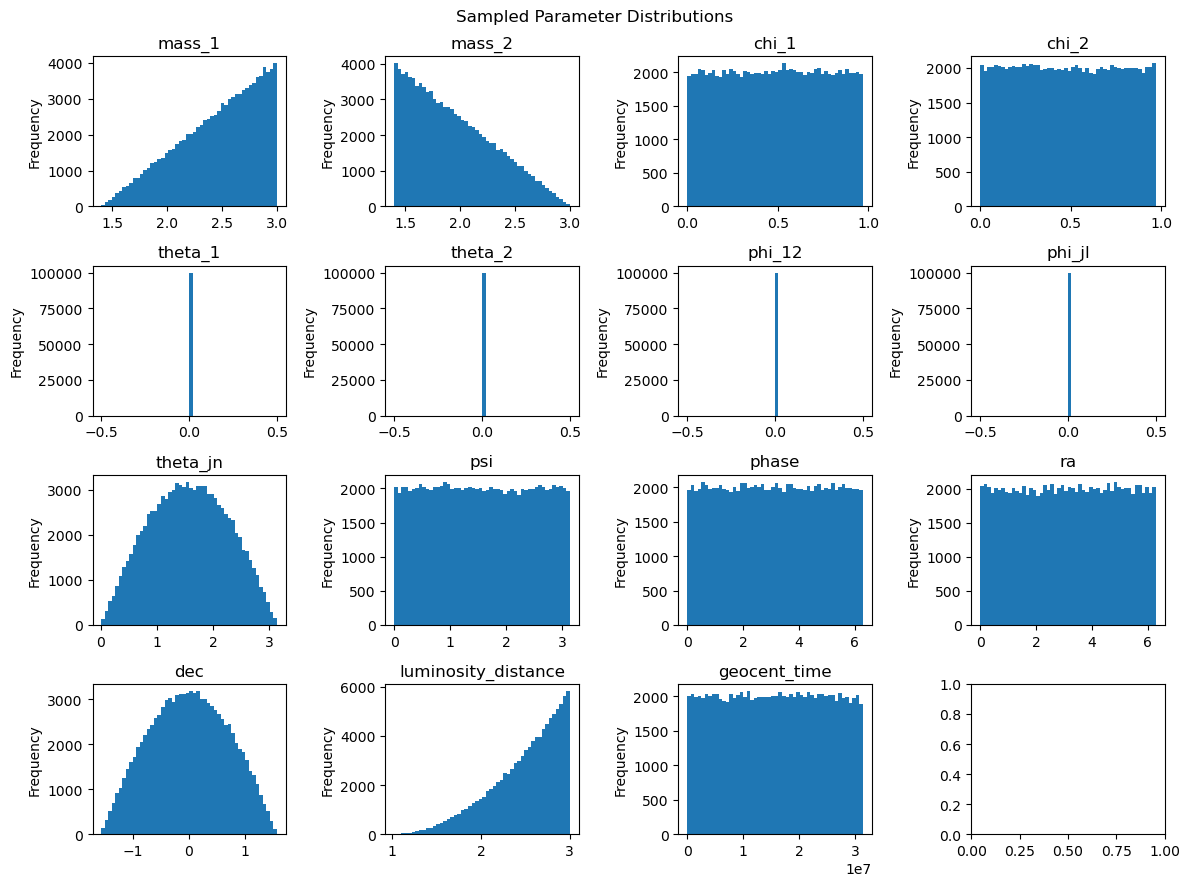

In [8]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,9), layout="tight", facecolor="white")
for i, key in enumerate(samples.columns):
    ax = axes[i // ncols, i % ncols]  # get axis at row (i // ncols) and col (i % ncols)
    samples[key].plot(kind="hist", bins=50, ax=ax, title=key)
fig.suptitle("Sampled Parameter Distributions")
fig.show()